# Learning Neural Differential Algebraic Equations via Operator Splitting

Implementation of the Tank-Manifold Property Inference Example from the paper:

[James Koch, Madelyn Shapiro, Himanshu Sharma, Draguna Vrabie, and Jan Drgona,Learning Neural Differential Algebraic Equations via Operator Splitting, Conference on Decision and Control (CDC), 2025.
](https://arxiv.org/abs/2403.12938)


Neural Differential Algebraic Equations (Neural DAEs) are an extension of the canonical neural timestepper for systems with algebraic constraints. Inspired by fractional-step methods, this work leverages sequential sub-tasks to provide updates for algebraic states and differential states.


Differential-Algebraic Equations (DAEs) are systems comprising differential and algebraic relationships that describe the evolution of a system's states. Specifically, we are concerned with semi-explicit DAEs written as:
$$
\begin{align}
    \frac{dx}{dt}   = f\left( x, y, u \right), \\
    0 = g\left(  x,y,u \right),
\end{align}
$$

where $x \in \mathbb{R}^{n_x}$ are the differential states of a system that evolve according to the vector field defined by $f: \mathbb{R}^{n_x}\times \mathbb{R}^{n_y}\times\mathbb{R}^{n_u} \to \mathbb{R}^{n_x} $, $y \in \mathbb{R}^{n_y}$ are the algebraic states, and $u \in \mathbb{R}^{n_u}$ are exogenous inputs.

In this example we aim to solve the following optimization problem:
$$
\begin{align}
&\underset{\theta_f}{\text{min}}     && \int_{t_0}^{t_N} \Big( ||x - \hat{x}||_2^2   +||y - \hat{y}||_2^2   \Big) \\
&\text{s.t}    &&
    \frac{dx}{dt}  = f(x(t), y(t), u(t); \theta_f) , \\
  &  &&  0  = g(x(t), y(t), u(t)), \\
  &  &&  x({t_0}) = x_0, \, \, \,  y({t_0}) = y_0,
\end{align}
$$

Here $\hat{x}, \hat{y}$ represent reference state variables generated by the unknown DAE system. The objective of the problem is to train the parameters $\theta_f$ of the neural DAE model such that the reference state trajectories in the time interval $[{t_0}, {t_N}]$ match the observed states.

### Install (Colab only)
Skip this step when running locally.

In [65]:
!pip install neuromancer

### Import necessary libraries

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import neuromancer.slim as slim
from neuromancer.modules import blocks
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.constraint import variable
from neuromancer.system import Node, System
from neuromancer.loggers import BasicLogger

In [67]:
# Set device and random seed
device = 'cpu'
seed = 136
np.random.seed(seed)
torch.manual_seed(seed)

### Dataset for DAE system
In this example we consider **Tank-Manifold-Pump** system characterized by conservation relationship that manifests as an algebraic constraint in the DAE.

Tank-Manifold-Pump schematics:
<img src="../figs/manifold.png" width="600">

differential equations:
$$
\begin{align}
    \frac{dx_1}{dt} = \frac{y_1}{\phi_1(x_1)}, \\
    \frac{dx_2}{dt} = \frac{y_2}{\phi_2(x_2)},
\end{align}
$$

algebraic equations:
$$
\begin{align}
  0 = y_{\text{in}} - y_1 - y_2, \\
  0 = x_1 - x_2,
 \end{align}
$$

Here $\phi_1$ and $\phi_2$ denote the area-height profiles for the two tanks. For this study, the area-height profiles are set to $\phi_1(x) = 3.0$ and $\phi_2(x) = \sqrt{x} + 0.1$ respectively. The goal of the learning task is to recover $\phi_2(x)$ given observations of tank heights $x$ and pump volumetric flow rates $y$.

At the manifold, the inflow is exactly equal to the sum of the outflows; that is, $y_{\text{in}} = y_1 + y_2$, where $y$ represents volumetric flow rates and the subscripts $1$ and $2$ denote the two exit streams of the manifold. The two tanks have different area-height profiles but share a common datum such that the column heights are identical. As a fluid is pumped into the two tanks, the flow rates in the two streams vary to ensure (i) the conservation relationship of the manifold and (ii) identical pressure head of the tanks, i.e, $x_1 = x_2$, where $x$ is the height of the fluid.

states - x:
$x_1$ - height of tank 1
$x_2$ - height of tank 2
$y_1$ - mass flow into tank 1 - index 2
$y_2$ - mass flow into tank 2 - index 3

inputs - u:
$y_{\text{in}}$   - mass flow into system



In [68]:
import requests

# Raw URL of area.dat
url = "https://raw.githubusercontent.com/pnnl/NeuralDAEs/master/training/area.dat"

# Download and save the file locally
response = requests.get(url)
with open("area.dat", "wb") as f:
    f.write(response.content)

In [69]:
# define problem dimensions
area_data = np.loadtxt('area.dat')
nx = 4
nu = 1
dt = 1.0

In [70]:
# add noise function
def add_snr(data, db):
    snr = 10 ** (db / 10)
    for i in range(data.shape[1]):
        signal_power = np.mean(data[:, i] ** 2)
        std_n = (signal_power / snr) ** 0.5
        if snr > 1e8:
            continue
        data[:, i] += np.random.normal(0, std_n, len(data[:, i]))
    return data

In [71]:
# load data from pre-computed DAE system
data = np.float32(np.loadtxt('tanks_splits.dat'))
data = data[:len(data) // 2, :]
data = data[1:, :]
db = 90
data = add_snr(data, db)
time = np.linspace(0.0, len(data)-1, len(data)).reshape(-1, 1).astype(np.float32) * dt
U = np.full_like(time, 0.5, dtype=np.float32)

train_data = {'X': torch.tensor(data),
              'U': torch.tensor(U),
              'Time': torch.tensor(time)}
dev_data = train_data.copy()
test_data = train_data.copy()

In [72]:
# set simulation steps and prediction horizon for system ID loss
nsim = data.shape[0]
nstep = 5

In [73]:
# reshape the data and for system ID optimization
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(nsim // nstep, nstep, nx)
    d['U'] = d['U'].reshape(nsim // nstep, nstep, nu)
    d['xn'] = d['X'][:, 0:1, :]
    d['Time'] = d['Time'].reshape(nsim // nstep, -1)

test_data['X'] = test_data['X'].reshape(1, nsim, nx)
test_data['U'] = test_data['U'].reshape(1, nsim, 1)
test_data['xn'] = test_data['X'][:, 0:1, :]
test_data['Time'] = test_data['Time'].reshape(nsim, -1)

In [74]:
# create data loaders
train_dataset, dev_dataset = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader, test_loader = [
    DataLoader(d, batch_size=nsim // nstep, collate_fn=d.collate_fn, shuffle=True)
    for d in [train_dataset, dev_dataset, dev_dataset]
]

### Define DAE system dynamics model


Using operator splitting to solve the semi-explicit DAE, we define the following neural time-stepper:
$$
    \begin{align}
        y^{(t+\Delta t)} & = h\left( x^{(t)},y^{(t)},u^{(t)} ; \theta_h\right), \\
        x^{(t+\Delta t)} &= \text{ODESolve}\left(f ,\{x^{(t)},y^{(t+\Delta t)}, u^{(t)}\}; \theta_f\right),
    \end{align}
$$

where $ h: \mathbb{R}^{n_x} \times \mathbb{R}^{n_y} \times \mathbb{R}^{n_u} \rightarrow \mathbb{R}^{n_y} $ is a neural surrogate for the algebraic update, and $\text{ODESolve}$ is an ODE solver.

Schematics of the Operator Splitting approach for Neural DAEs:
<img src="../figs/fig_01.png" width="600">

In the following we define the algebraic neural solver and the physics-structured ODE part of the system.


In [75]:
# Define the algebra surrogate
class AlgebraSolver(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, x, u):
        if x.ndim == 1:
            x = x.unsqueeze(0)  # Ensure batch dimension

        # get differential states
        h1 = x[:, 0].unsqueeze(-1)
        h2 = x[:, 1].unsqueeze(-1)
        # get the mass flow input
        m = u[:, 0].unsqueeze(-1)

        # get the mass flow outputs through the algebra solver
        in_algebra = torch.cat([h1, h2], dim=-1)
        param = torch.abs(self.net(in_algebra))
        m1 = m * param
        m2 = m * (1.0 - param)

        # update algebra states
        x_new = x.clone()
        x_new[:, 2] = m1.squeeze(-1)
        x_new[:, 3] = m2.squeeze(-1)
        return x_new


In [76]:
# define the physics-structured ODE part of the system
class TankManifoldDynamics(ode.ODESystem):
    def __init__(self, net, insize=nx, outsize=nx):
        super().__init__(insize=insize, outsize=outsize)
        self.net = net

    def ode_equations(self, x):
        # get the differential and algebraic states
        h1 = x[:, 0].unsqueeze(-1)
        h2 = x[:, 1].unsqueeze(-1)
        m1 = x[:, 2].unsqueeze(-1)
        m2 = x[:, 3].unsqueeze(-1)
        # get the area
        A1 = 3.0 * torch.ones_like(h1)
        A2 = self.net(h2)
        # compute the differential states
        dh1 = m1 / A1
        dh2 = m2 / A2
        # update differential states
        dx = torch.zeros_like(x)
        dx[:, 0] = dh1.squeeze(-1)
        dx[:, 1] = dh2.squeeze(-1)
        return dx

### Instantiate the neural DAE model

Puttings thing together we obtain neural DAE model in the form:

$$
 \{x^{(t+\Delta t)},y^{(t+\Delta t)}\} =
        \text{DAESolve} \left(f,h,\{x^{(t)}, y^{(t)}, u^{(t)}\};\Theta\right),
$$
 where $\Theta = \{\theta_h,\theta_f\}$ is the set of all model parameters, and the temporal integration bounds are assumed to be  $[t, t+ \Delta t]$.

In [77]:
# define neural component of the algebra solver
algebra_net = blocks.MLP(insize=2, outsize=1, hsizes=[3],
                         linear_map=slim.maps['linear'], nonlin=nn.Sigmoid)
# instantiate the algebra solver and wrap it in a Node
algebra = Node(AlgebraSolver(algebra_net), ['xn', 'U'],
               ['x_alg'], name='algebra')

In [78]:
# define neural component of the ODE part
tank_profile = blocks.MLP(insize=1, outsize=1, hsizes=[5],
                          linear_map=slim.maps['linear'], nonlin=nn.Sigmoid)
# Instantiate ODE model
ode_dynamics = TankManifoldDynamics(tank_profile)
fx_int = integrators.RK4(ode_dynamics, h=dt)
ode_node = Node(fx_int, ['x_alg'],
                ['xn'], name='ode_node')

In [79]:
# Compose DAE system via operator splitting approach
dynamics_model = System([algebra, ode_node], nsteps=nstep)

### Define the optimization problem

We define the loss function to match the differential states and algebraic states of the modeled system $X$ with the observed states $\hat{X}$.

$$
 \mathcal{L}(\Theta) = \mathcal{L}_{\text{residual}}(X,\hat{X};\Theta)
$$


In [80]:
# track differential and algebraic states
x = variable("X")
xhat = variable("xn")[:, :-1, :]
reference_loss = ((xhat == x) ^ 2)
reference_loss.name = "ref_loss"

In [81]:
# define the loss function
loss = PenaltyLoss([reference_loss], [])
problem = Problem([dynamics_model], loss)

### Instantiate the Trainer and train the model


In [82]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
logger = BasicLogger(args=None, savedir='test', verbosity=10,
                     stdout=["dev_loss", "train_loss"])

trainer = Trainer(
    problem, train_loader, dev_loader, test_loader, optimizer,
    epochs=20000, patience=100, warmup=100,
    eval_metric="dev_loss", train_metric="train_loss",
    dev_metric="dev_loss", test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 29


In [83]:
#train the model
trained_model_dict = trainer.train()

epoch: 0	train_loss: 1.08393	dev_loss: 1.05159	eltime:  0.04200
epoch: 10	train_loss: 0.80642	dev_loss: 0.78379	eltime:  0.22584
epoch: 20	train_loss: 0.61390	dev_loss: 0.59830	eltime:  0.41749
epoch: 30	train_loss: 0.48077	dev_loss: 0.46989	eltime:  0.60741
epoch: 40	train_loss: 0.38696	dev_loss: 0.37917	eltime:  0.79972
epoch: 50	train_loss: 0.31883	dev_loss: 0.31306	eltime:  0.98780
epoch: 60	train_loss: 0.26766	dev_loss: 0.26325	eltime:  1.16356
epoch: 70	train_loss: 0.22804	dev_loss: 0.22457	eltime:  1.34343
epoch: 80	train_loss: 0.19656	dev_loss: 0.19376	eltime:  1.51873
epoch: 90	train_loss: 0.17103	dev_loss: 0.16874	eltime:  1.69636
epoch: 100	train_loss: 0.14998	dev_loss: 0.14808	eltime:  1.87588
epoch: 110	train_loss: 0.13241	dev_loss: 0.13081	eltime:  2.04475
epoch: 120	train_loss: 0.11759	dev_loss: 0.11624	eltime:  2.23257
epoch: 130	train_loss: 0.10498	dev_loss: 0.10383	eltime:  2.41030
epoch: 140	train_loss: 0.09420	dev_loss: 0.09320	eltime:  2.60037
epoch: 150	train_loss

### Evaluate the trained model

In [84]:
# do the full simulation rollout
dynamics_model.nsteps = nsim
# Use model to predict trajectory on test data
test_outputs = dynamics_model(test_data)


In [85]:
# Retrieve predictions and ground truth
pred_traj = test_outputs['xn'][:, :-1, :]  # skip final since it's predicted
true_traj = test_data['X'][:, :-1, :]      # match prediction horizon

# Reshape to [nx, time]
pred_traj = pred_traj.detach().numpy().reshape(-1, nx).T
true_traj = true_traj.detach().numpy().reshape(-1, nx).T

In [86]:
# ---------------------------------------
# Plotting Style
# ---------------------------------------
plt.style.use('default')
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({
    'font.size': 10,
    'legend.fontsize': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})


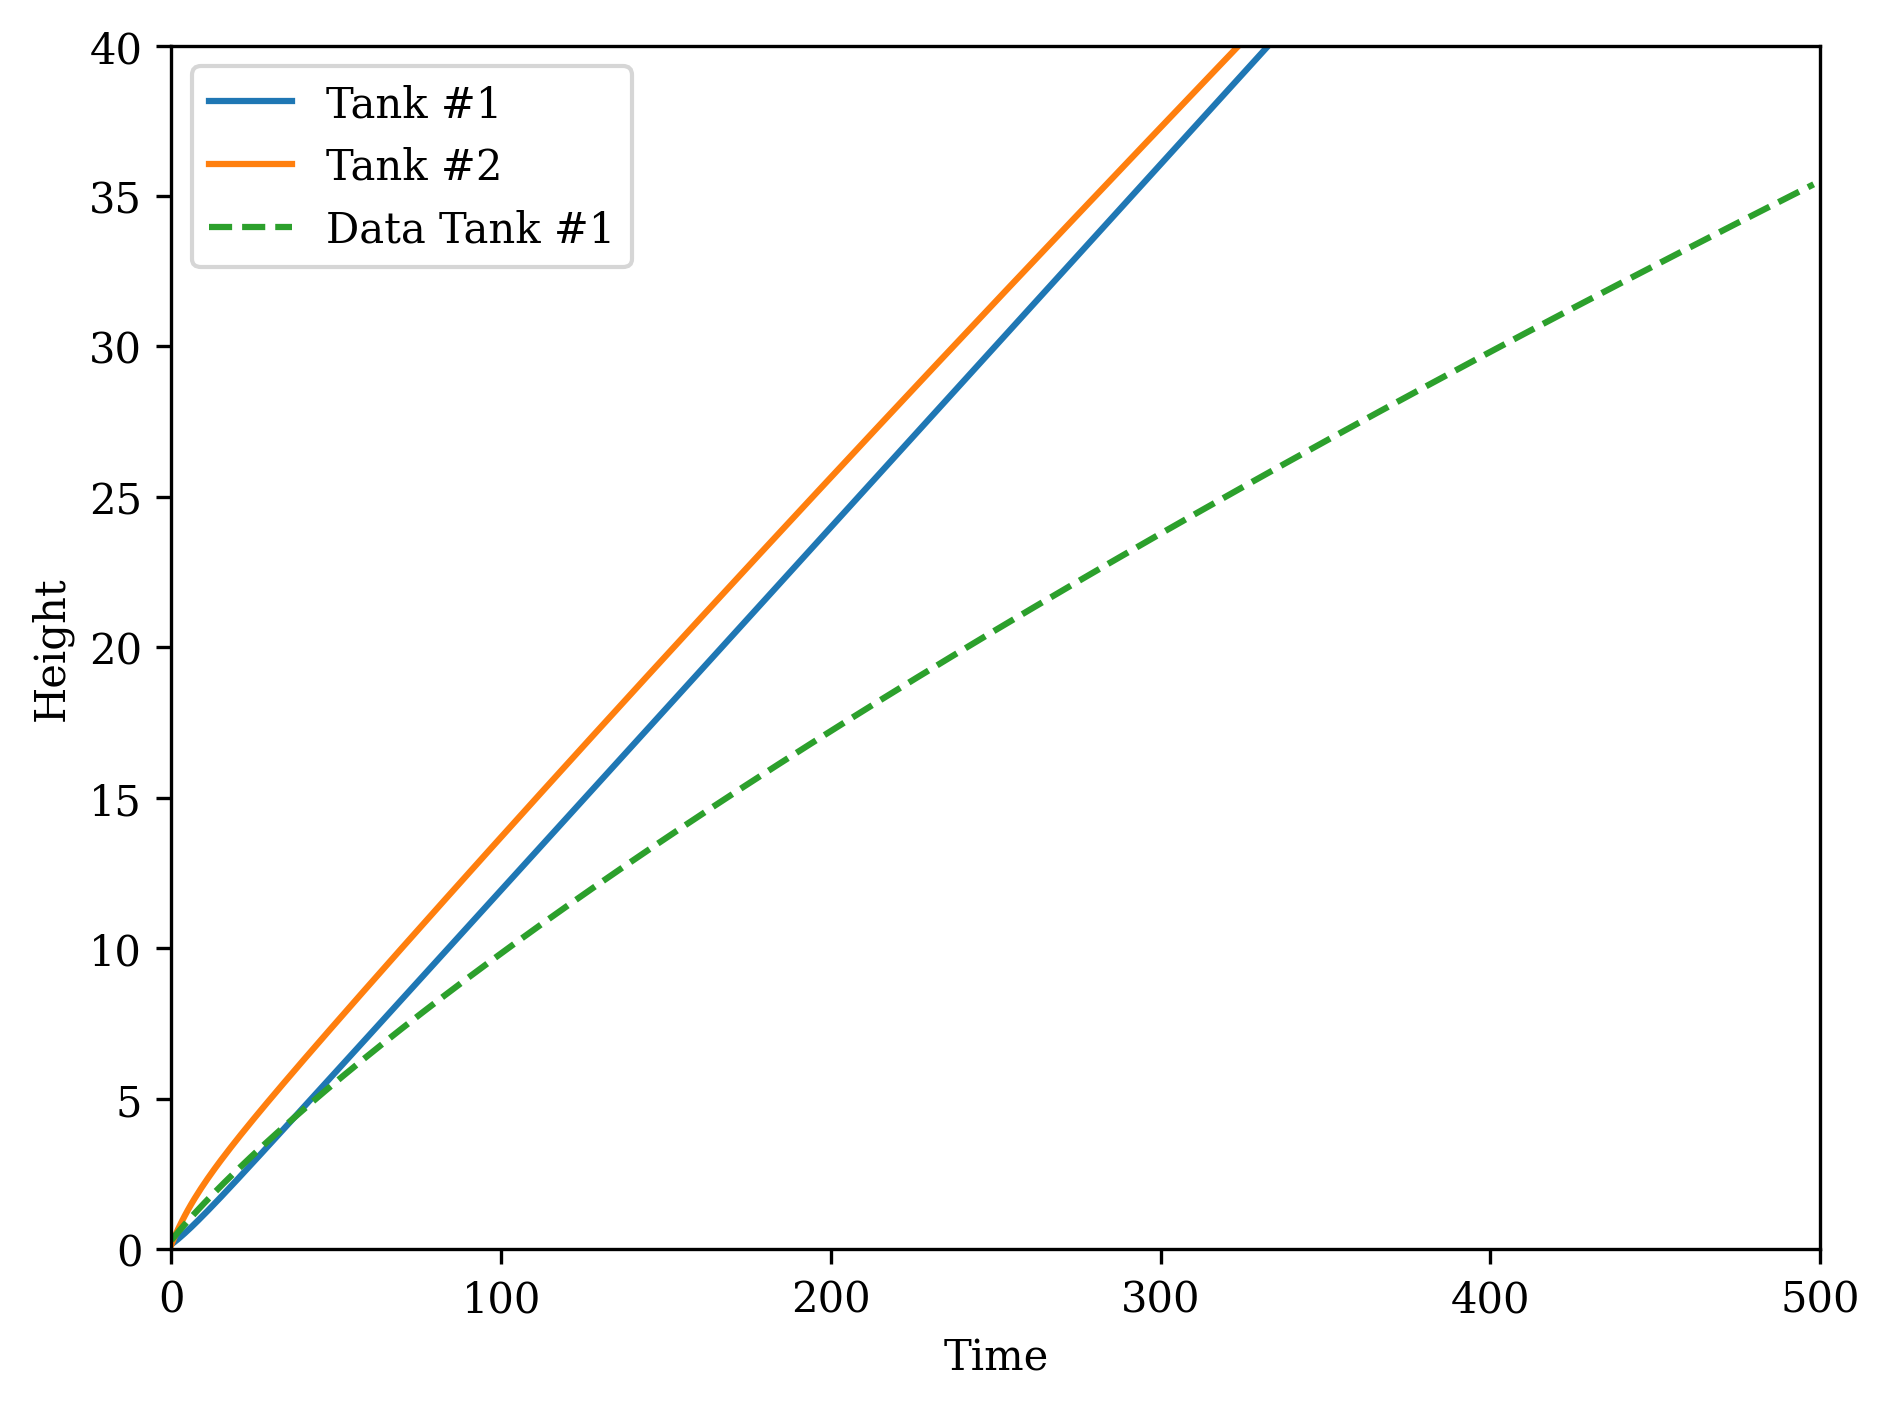

In [87]:
# ---------------------------------------
# Tank Heights
# ---------------------------------------
plt.figure()
plt.plot(time, pred_traj[0], label="Tank #1")
plt.plot(time, pred_traj[1], label="Tank #2")
plt.plot(time[:-1], data[1:, 0], linestyle='--', label="Data Tank #1")
plt.xlim([0, 500])
plt.ylim([0, 40])
plt.xlabel("Time")
plt.ylabel("Height")
plt.legend()
plt.tight_layout()
plt.savefig(f'tanks_{db}.png')
plt.show()


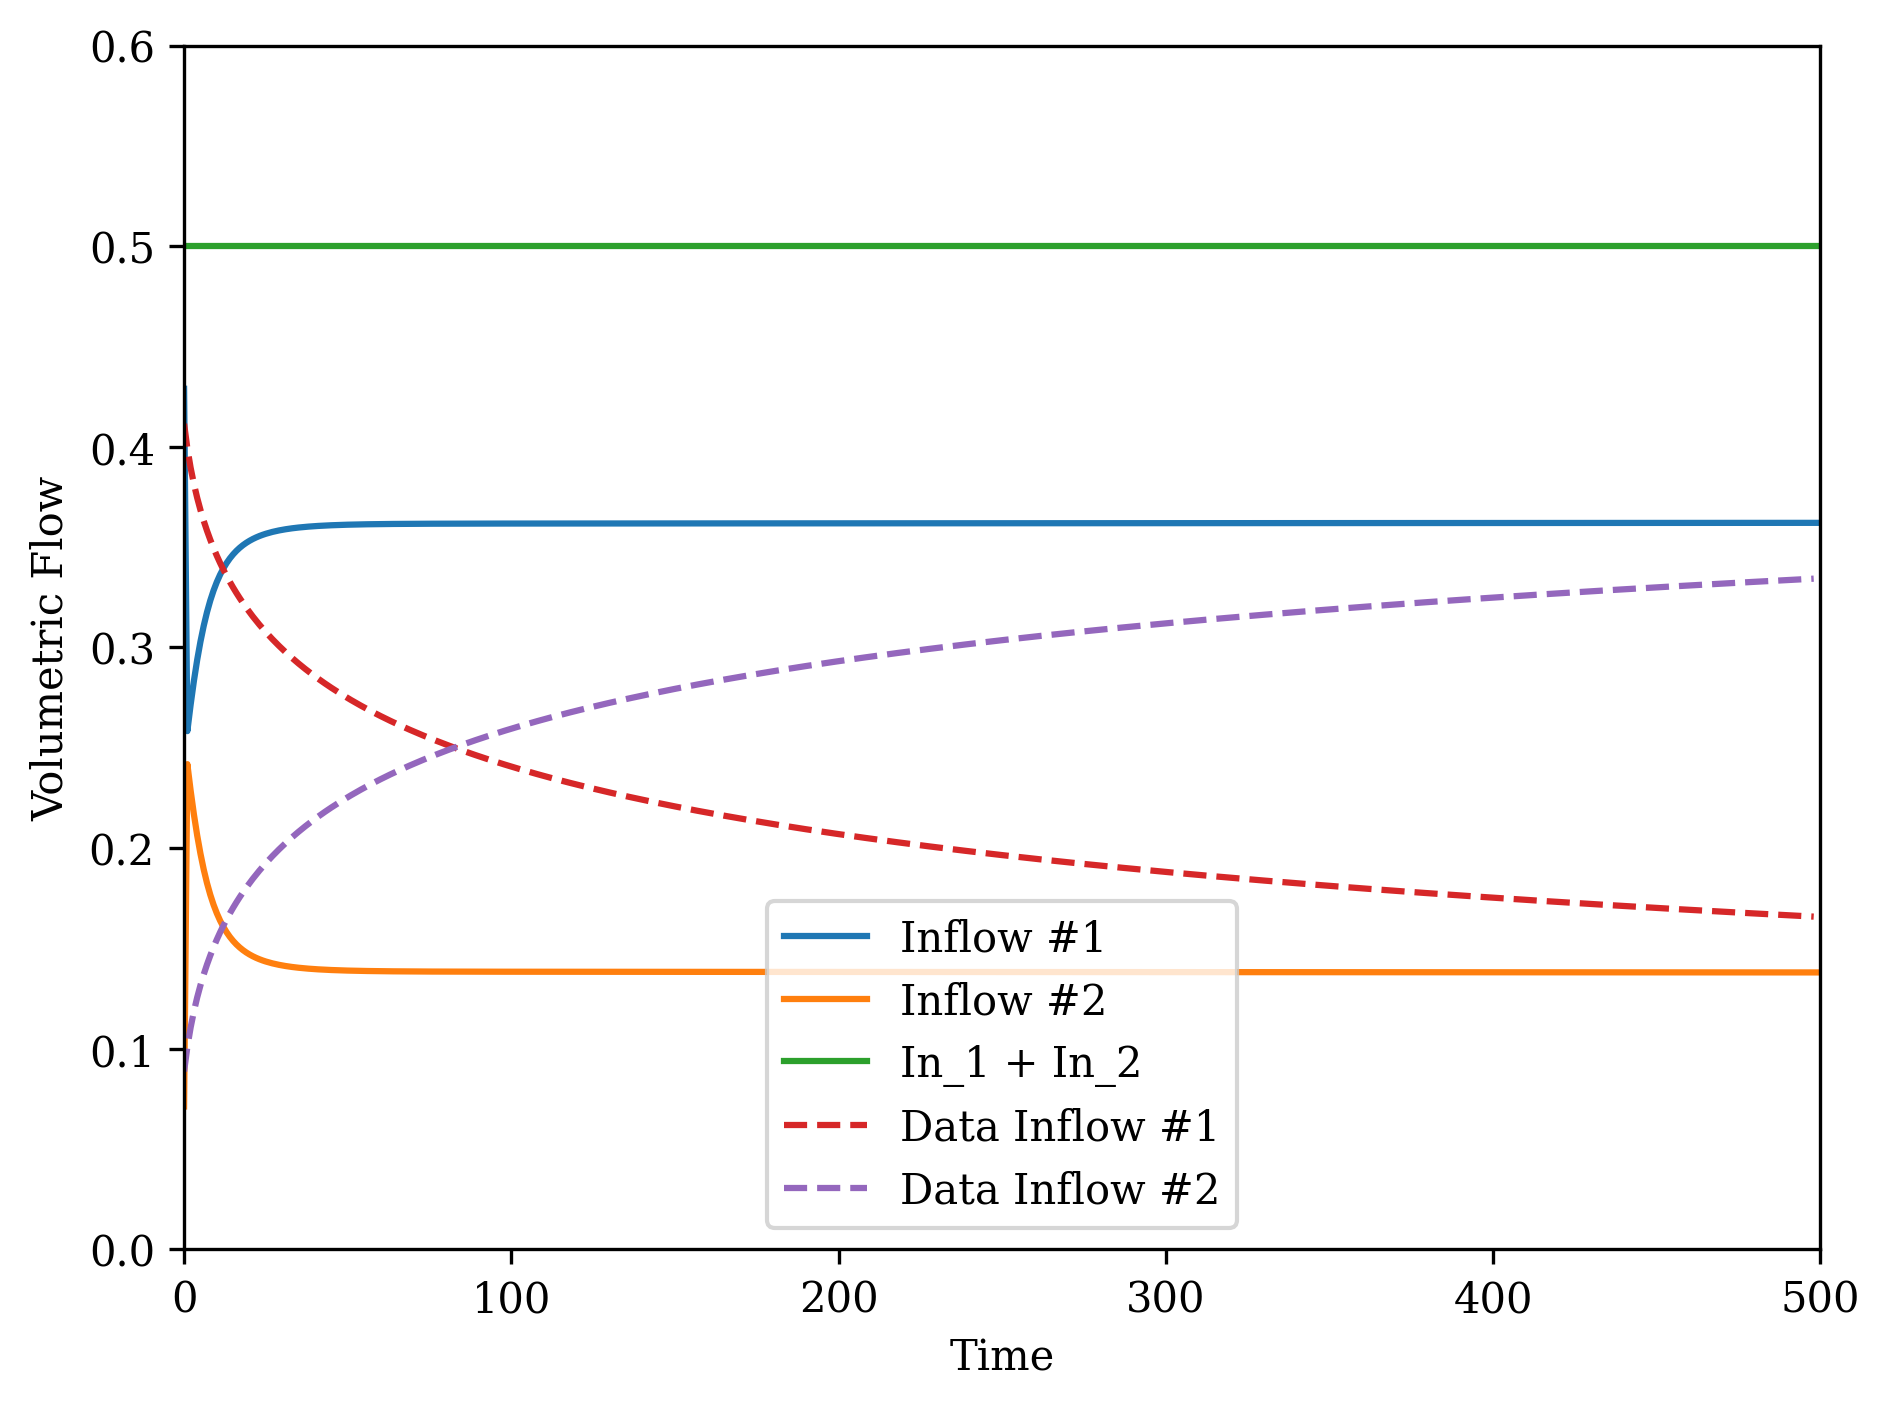

In [88]:
# ---------------------------------------
# Mass Flows
# ---------------------------------------
plt.figure()
plt.plot(time, pred_traj[2], label="Inflow #1")
plt.plot(time, pred_traj[3], label="Inflow #2")
plt.plot(time, pred_traj[2] + pred_traj[3], label="In_1 + In_2")
plt.plot(time[:-1], data[1:, 2], linestyle='--', label="Data Inflow #1")
plt.plot(time[:-1], data[1:, 3], linestyle='--', label="Data Inflow #2")
plt.xlim([0, 500])
plt.ylim([0, 0.6])
plt.xlabel("Time")
plt.ylabel("Volumetric Flow")
plt.legend()
plt.tight_layout()
plt.savefig(f'flows_{db}.png')
plt.show()

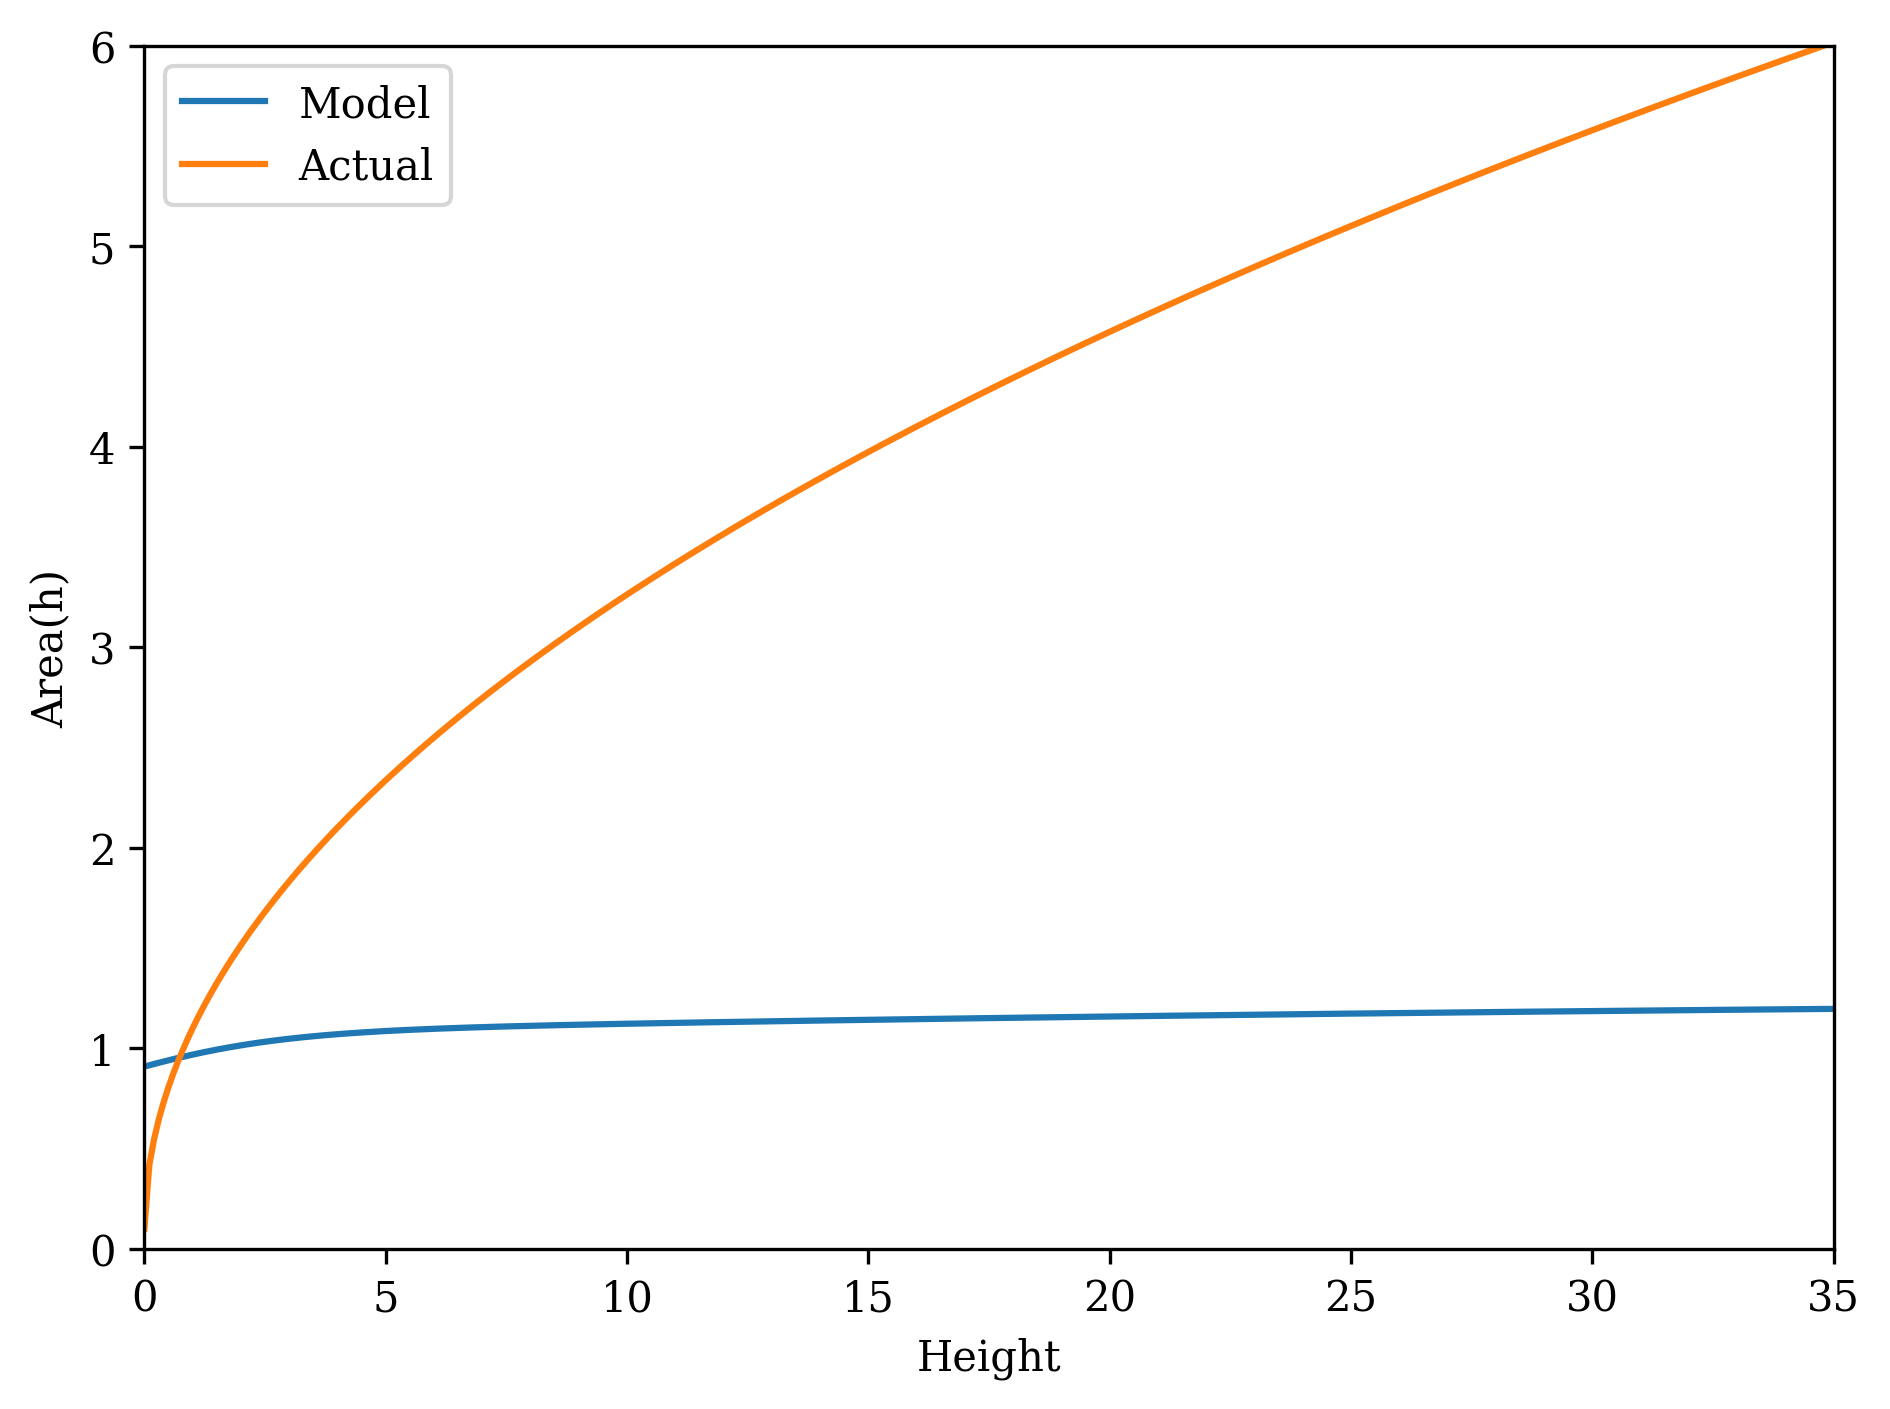

In [89]:
# ---------------------------------------
# Area-Height Relationship
# ---------------------------------------
h = torch.linspace(0, 40, 401).unsqueeze(-1).float()
area = tank_profile(h).detach().numpy()

plt.figure()
plt.plot(h.numpy(), area, label="Model")
plt.plot(h.numpy(), area_data, label="Actual")
plt.ylim([0, 6])
plt.xlim([0, 35])
plt.xlabel("Height")
plt.ylabel("Area(h)")
plt.legend()
plt.tight_layout()
plt.savefig(f'areas_{db}.png')
plt.show()

### Extrapolation to unseen data

In [90]:
# Eval on new conditions with sinusoidal input
nsteps = 501
data = np.float32(np.loadtxt('tanks_splits.dat'))
data = data[nsteps:, ]
time = np.float32(np.linspace(0.0, len(data[:, 0]) - 1, len(data[:, 0])).reshape(-1, 1)) * dt
U = time * 0.0 + 0.5 + 0.25 * np.sin(time / 100.0)
U_torch = torch.tensor(U).reshape(1, -1, nu)
# update dictionary dataset
test_data['U'] = U_torch
test_data['X'] = torch.tensor(data).reshape(1, -1, nx)
test_data['xn'] = test_data['X'][:, 0:1, :]  # new initial state

In [91]:
# Use model to predict trajectory on test data
test_outputs = dynamics_model(test_data)

# Retrieve predictions and ground truth
pred_traj = test_outputs['xn'][:, :-1, :]  # skip final since it's predicted
true_traj = test_data['X'][:, :-1, :]      # match prediction horizon

# Reshape to [nx, time]
pred_traj = pred_traj.detach().numpy().reshape(-1, nx).T
true_traj = true_traj.detach().numpy().reshape(-1, nx).T

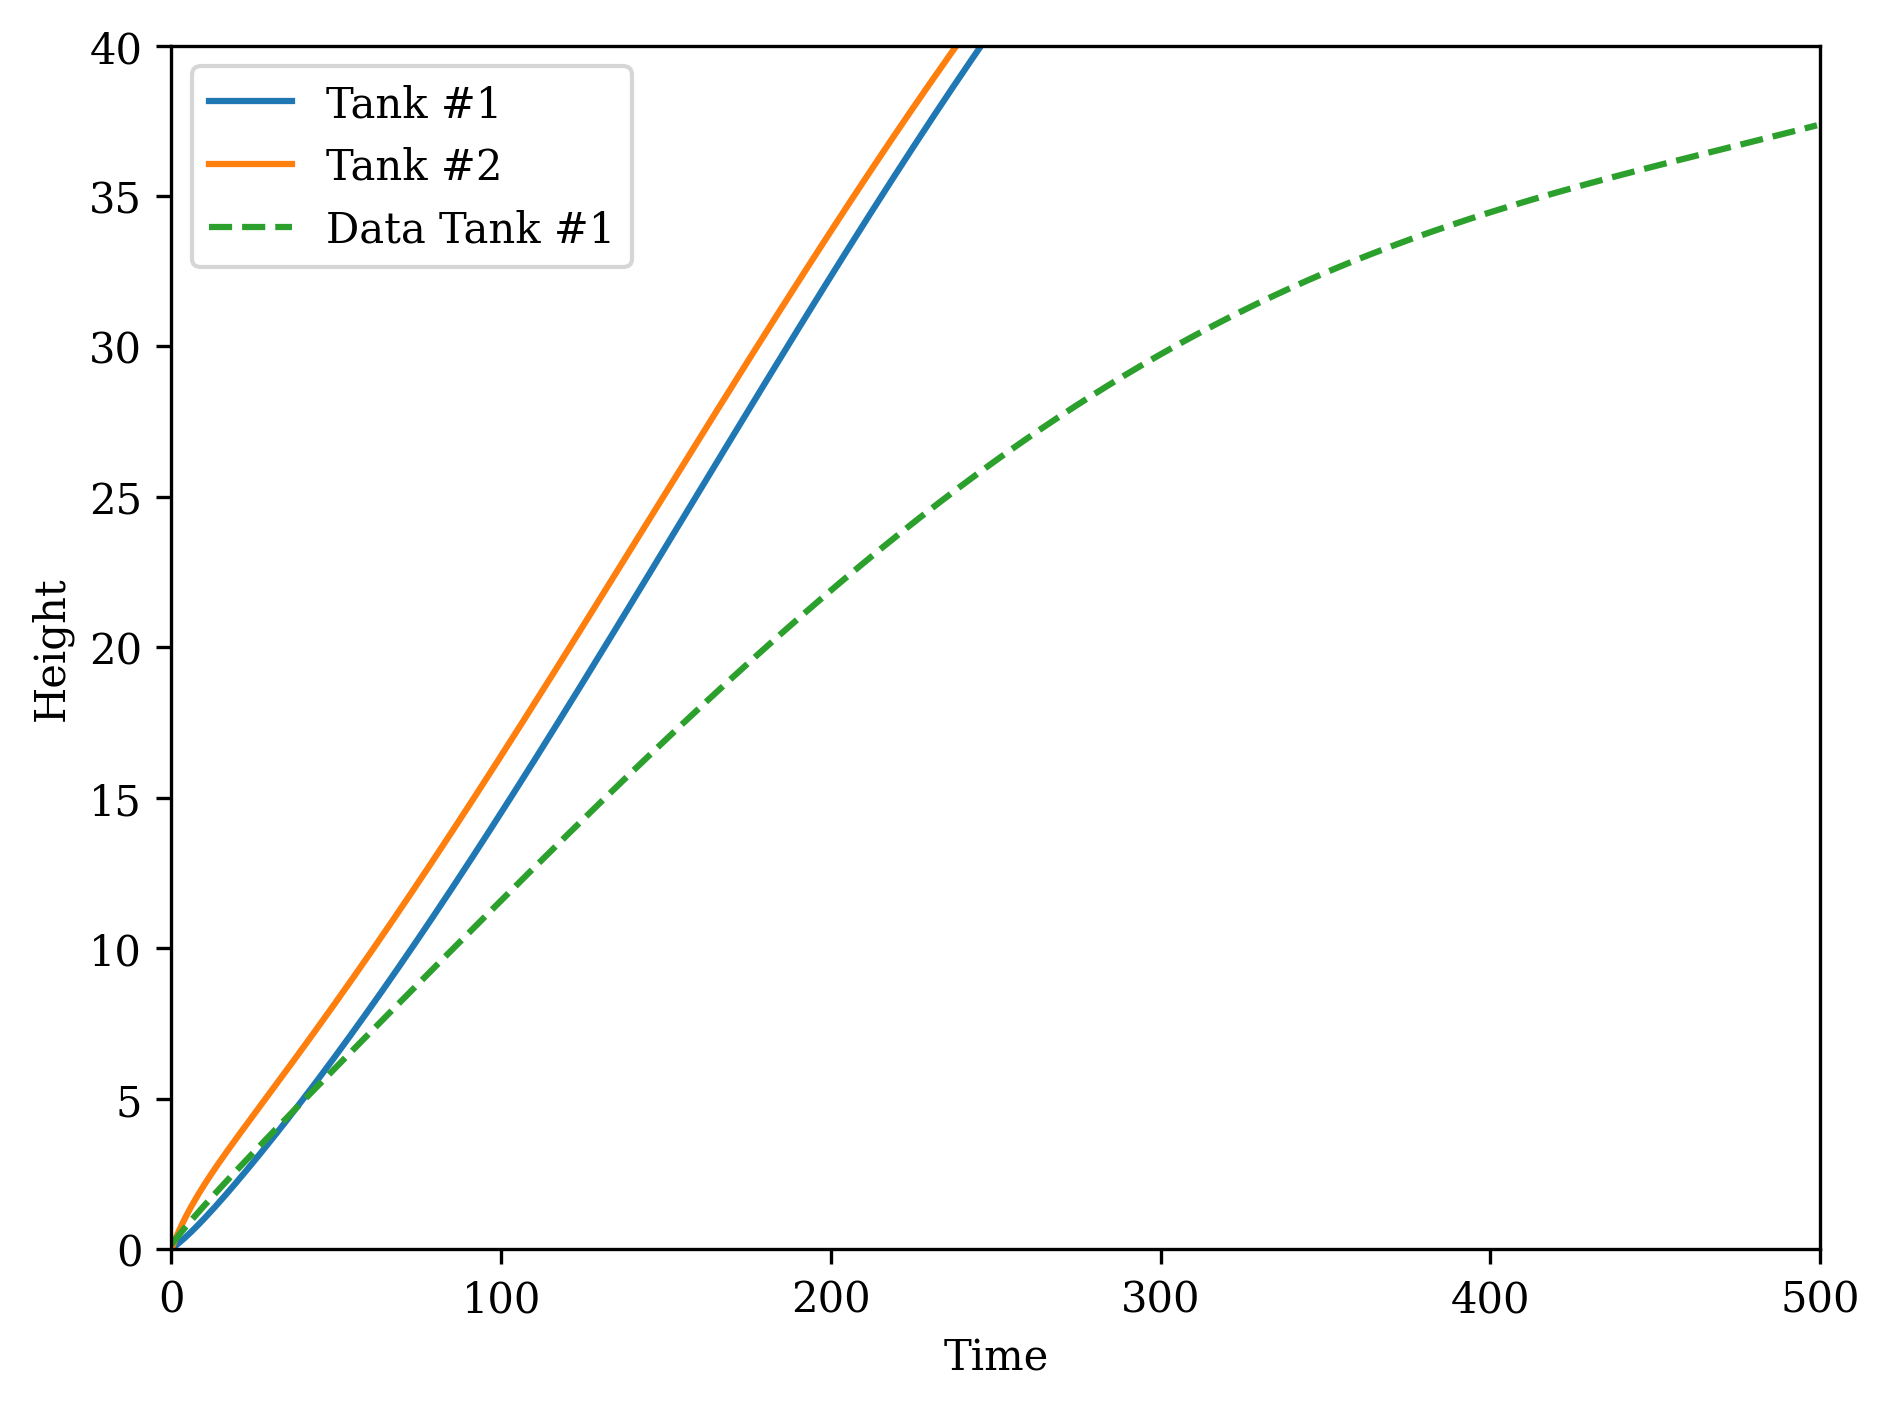

In [92]:
# ---------------------------------------
# Tank Heights
# ---------------------------------------
plt.figure()
plt.plot(time[:-1], pred_traj[0], label="Tank #1")
plt.plot(time[:-1], pred_traj[1], label="Tank #2")
plt.plot(time[:-1], data[1:, 0], linestyle='--', label="Data Tank #1")
plt.xlim([0, 500])
plt.ylim([0, 40])
plt.xlabel("Time")
plt.ylabel("Height")
plt.legend()
plt.tight_layout()
plt.savefig(f'tanks_{db}.png')
plt.show()

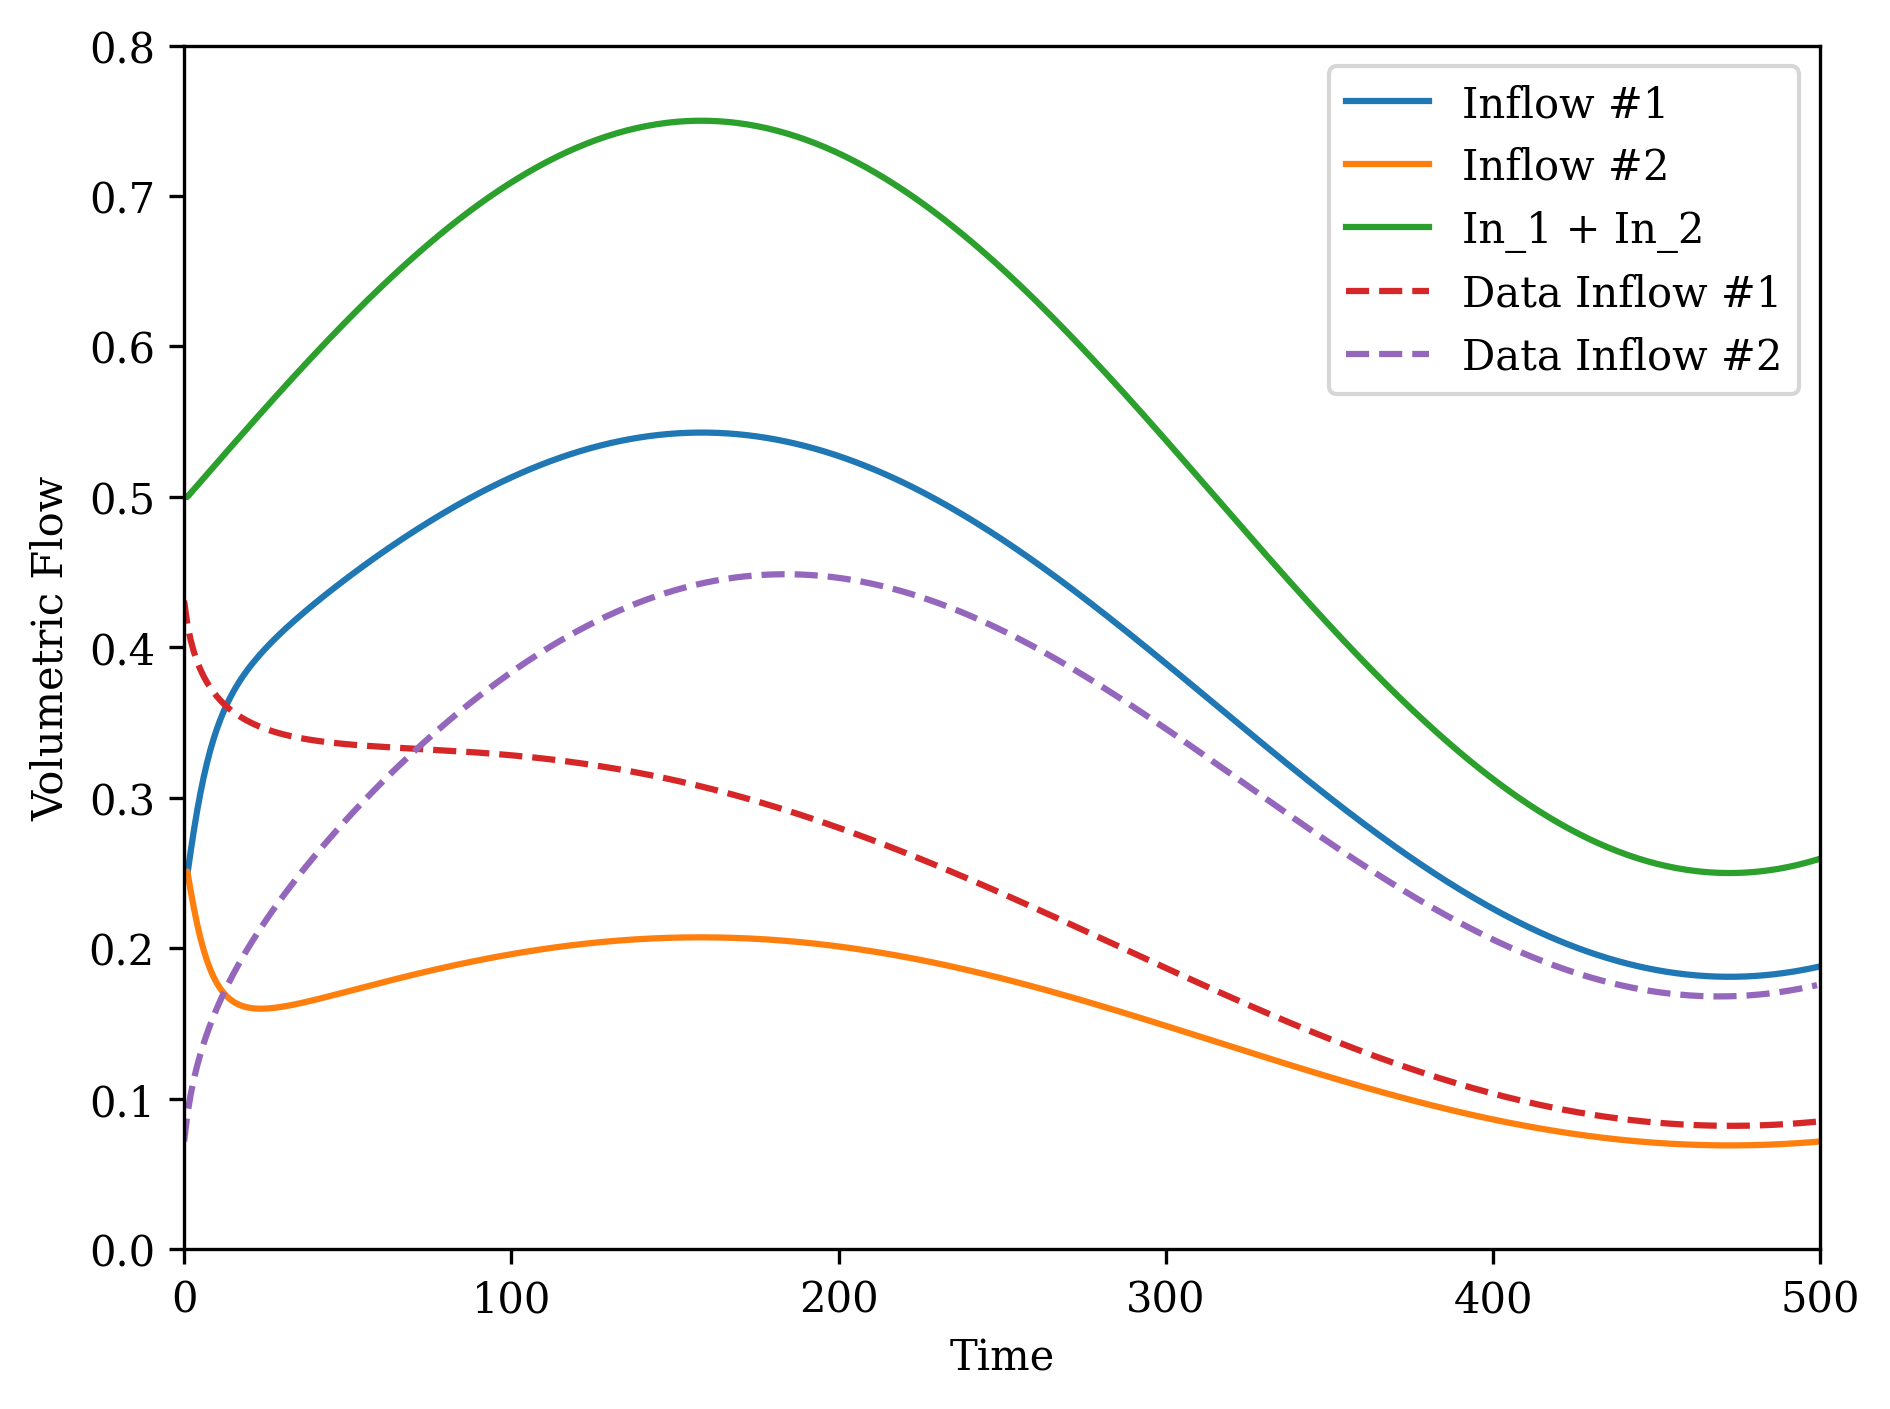

In [93]:
# ---------------------------------------
# Mass Flows
# ---------------------------------------
plt.figure()
plt.plot(time[:-1], pred_traj[2], label="Inflow #1")
plt.plot(time[:-1], pred_traj[3], label="Inflow #2")
plt.plot(time[:-1], pred_traj[2] + pred_traj[3], label="In_1 + In_2")
plt.plot(time[:-1], data[1:, 2], linestyle='--', label="Data Inflow #1")
plt.plot(time[:-1], data[1:, 3], linestyle='--', label="Data Inflow #2")
plt.xlim([0, 500])
plt.ylim([0, 0.8])
plt.xlabel("Time")
plt.ylabel("Volumetric Flow")
plt.legend()
plt.tight_layout()
plt.savefig(f'extrap_flows_{db}.png')
plt.show()

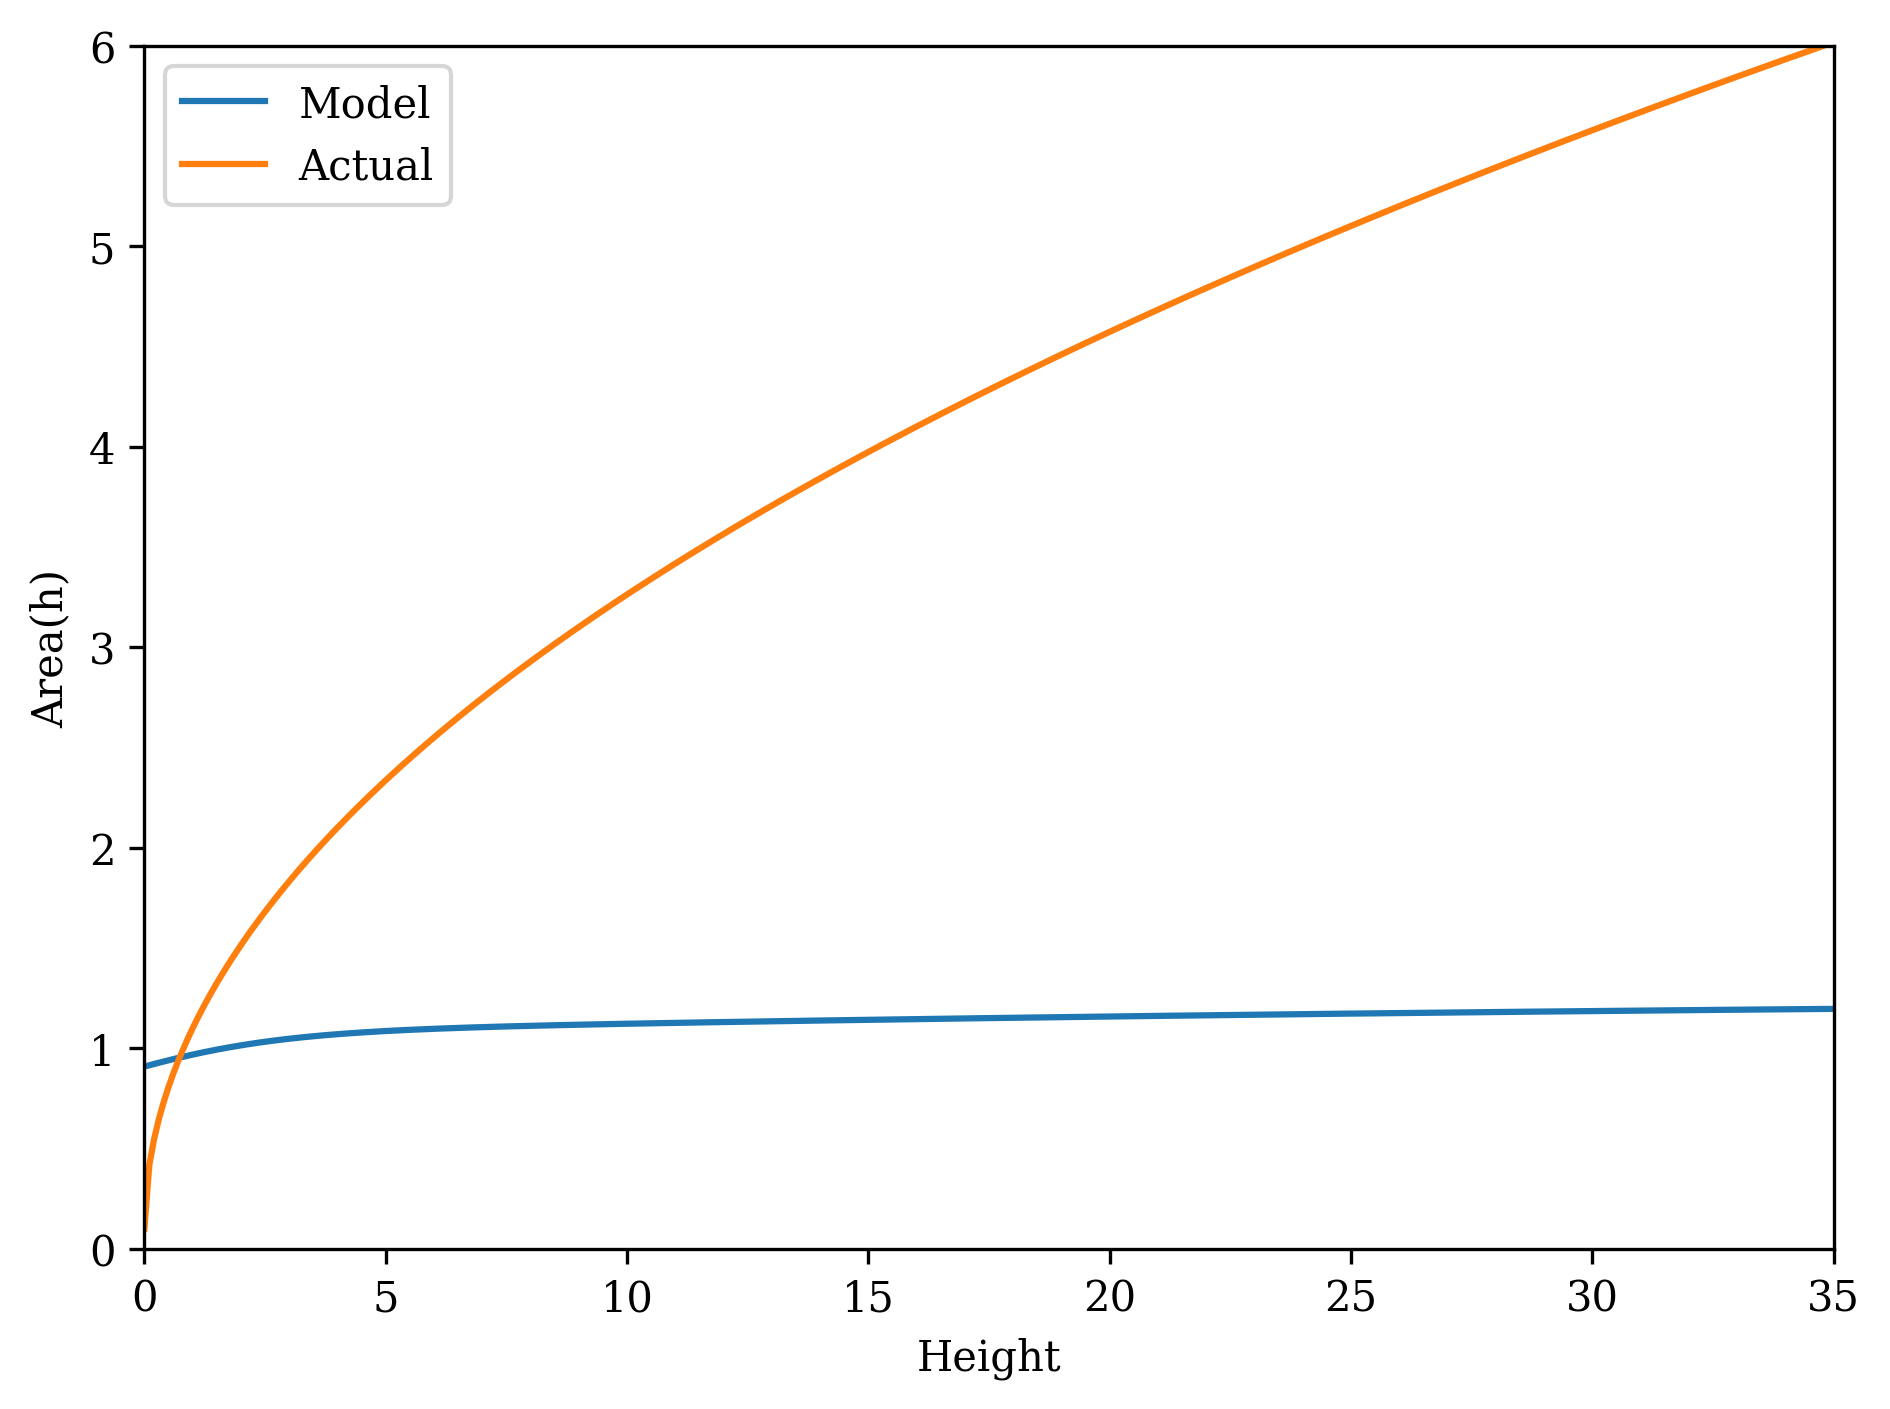

In [94]:
# ---------------------------------------
# Area-Height Relationship
# ---------------------------------------
h = torch.linspace(0, 40, 401).unsqueeze(-1).float()
area = tank_profile(h).detach().numpy()

plt.figure()
plt.plot(h.numpy(), area, label="Model")
plt.plot(h.numpy(), area_data, label="Actual")
plt.ylim([0, 6])
plt.xlim([0, 35])
plt.xlabel("Height")
plt.ylabel("Area(h)")
plt.legend()
plt.tight_layout()
plt.savefig(f'extrap_areas_{db}.png')
plt.show()

### Conclusion

This work presents a data-driven framework for modeling differential algebraic equations (DAEs) using a novel operator splitting (OS) method for Neural DAEs.  Inspired by Lie-Trotter splitting, our approach sequentially updates algebraic states via a differentiable surrogate and integrates differential states using an ODE solver.
The effectiveness of the proposed method is demonstrated by (i) modeling networked dynamical systems with algebraic constraints and (ii) showing generalization to unseen process conditions or component variation. Furthermore, demonstrate robustness to noise and extrapolation to (i) learn the behaviors of the DAE system components and their interaction physics and (ii) disambiguate between data trends and mechanistic relationships contained in the DAE system.
